### [모듈 로딩] <hr>

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import random_split 

#### [ 데이터 크롤링 ] <hr>

In [4]:
from icrawler.builtin import GoogleImageCrawler

def download_google_images(keyword, dir_name, max_num=100):
    crawler = GoogleImageCrawler(storage={'root_dir': dir_name})
    crawler.crawl(keyword=keyword, max_num=max_num)

if __name__ == '__main__':
    # 화재 이미지 다운로드 (Positive)
    download_google_images('화재, 산불, 불, fire, forestfire', 'train_data/fire', max_num=100)

    # 홍수 이미지 다운로드 (Negative)
    download_google_images('홍수, 재난, flood, flash flood', 'train_data/others', max_num=100)
    download_google_images('자연재해', 'train_data/others', max_num=100) 

2025-04-04 13:34:58,266 - INFO - icrawler.crawler - start crawling...
2025-04-04 13:34:58,267 - INFO - icrawler.crawler - starting 1 feeder threads...
2025-04-04 13:34:58,267 - INFO - feeder - thread feeder-001 exit
2025-04-04 13:34:58,267 - INFO - icrawler.crawler - starting 1 parser threads...
2025-04-04 13:34:58,267 - INFO - icrawler.crawler - starting 1 downloader threads...
2025-04-04 13:34:59,917 - INFO - parser - parsing result page https://www.google.com/search?q=%ED%99%94%EC%9E%AC%2C+%EC%82%B0%EB%B6%88%2C+%EB%B6%88%2C+fire%2C+forestfire&ijn=0&start=0&tbs=&tbm=isch
2025-04-04 13:35:00,017 - INFO - downloader - skip downloading file 000001.png
2025-04-04 13:35:00,017 - INFO - downloader - skip downloading file 000002.png
2025-04-04 13:35:00,017 - INFO - downloader - skip downloading file 000003.jpg
2025-04-04 13:35:00,017 - INFO - downloader - skip downloading file 000004.jpg
2025-04-04 13:35:00,017 - INFO - downloader - skip downloading file 000005.jpg
2025-04-04 13:35:00,017 -

In [5]:

# ------------------------------
# 1. Transform (전처리)
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((150, 150)),     # 이미지 크기 통일
    transforms.ToTensor(),             # 텐서 변환
    transforms.Normalize((0.5,), (0.5,))  # 정규화 (선택)
])

# ------------------------------
# 2. ImageFolder로 Dataset 만들기
# ------------------------------
dataset = datasets.ImageFolder(root='train_data', transform=transform)

# ------------------------------
# 3. DataLoader 만들기
# ------------------------------
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# ------------------------------
# 4. 클래스 정보 확인
# ------------------------------
print(dataset.classes)  # ['fire', 'others']
print(dataset.class_to_idx)  # {'fire': 0, 'others': 1}


['fire', 'others']
{'fire': 0, 'others': 1}


torch.Size([16, 3, 150, 150])


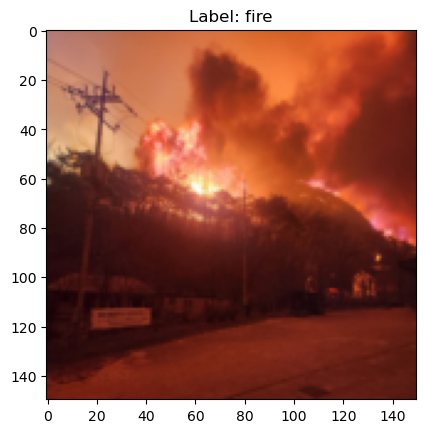

In [6]:

# 배치 하나 확인
images, labels = next(iter(dataloader))
print(images.shape)  # torch.Size([16, 3, 150, 150])

# 첫 번째 이미지 시각화
img = images[3].permute(1, 2, 0).numpy()
plt.imshow((img + 1) / 2)  # 정규화 해제
plt.title(f'Label: {dataset.classes[labels[0]]}')
plt.show()


['fire', 'others']
Epoch [1/10], Loss: 19.4224, Accuracy: 0.7709
Epoch [2/10], Loss: 8.6070, Accuracy: 0.8845
Epoch [3/10], Loss: 4.5083, Accuracy: 0.9542
Epoch [4/10], Loss: 2.2648, Accuracy: 0.9741
Epoch [5/10], Loss: 1.4797, Accuracy: 0.9880
Epoch [6/10], Loss: 0.5131, Accuracy: 0.9960
Epoch [7/10], Loss: 0.2115, Accuracy: 0.9980
Epoch [8/10], Loss: 0.0811, Accuracy: 1.0000
Epoch [9/10], Loss: 0.0492, Accuracy: 1.0000
Epoch [10/10], Loss: 0.0326, Accuracy: 1.0000
학습 완료!
예측 결과: fire (실제: fire)


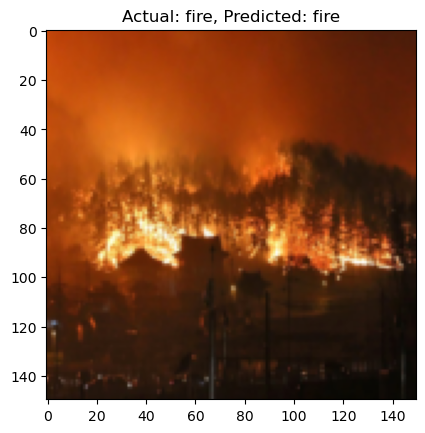

In [7]:


# =============================
# 1. 하이퍼파라미터 설정
# =============================
EPOCHS = 10       # 학습 횟수
BATCH_SIZE = 16   # 배치 크기
LEARNING_RATE = 0.001

# =============================
# 2. 데이터 불러오기
# =============================
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # 이미지 크기 통일
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 정규화
])

dataset = datasets.ImageFolder(root='train_data', transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 클래스 정보 확인
print(dataset.classes)  # ['fire', 'others']

# =============================
# 3. CNN 모델 정의
# =============================
class FireCNN(nn.Module):
    def __init__(self):
        super(FireCNN, self).__init__()
        # 합성곱 층
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 입력 3채널 → 16채널
        self.pool = nn.MaxPool2d(2, 2)               # Max Pooling
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 16채널 → 32채널

        # 완전연결층 (분류기)
        self.fc1 = nn.Linear(32 * 37 * 37, 64)
        self.fc2 = nn.Linear(64, 2)  # 클래스 수: fire / others

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (3,150,150) → (16,75,75)
        x = self.pool(F.relu(self.conv2(x)))  # (16,75,75) → (32,37,37)
        x = x.view(-1, 32 * 37 * 37)          # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                      # 출력층
        return x

# =============================
# 4. 학습 준비
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FireCNN().to(device)
criterion = nn.CrossEntropyLoss()  # 이진분류 → CrossEntropyLoss 사용
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# =============================
# 5. 학습 루프
# =============================
for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()  # 학습 모드
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()            # 기울기 초기화
        outputs = model(images)          # 순전파
        loss = criterion(outputs, labels) # 손실 계산
        loss.backward()                  # 역전파
        optimizer.step()                 # 가중치 업데이트

        running_loss += loss.item()
        # 정확도 계산
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss:.4f}, Accuracy: {acc:.4f}')

print('학습 완료!')

# =============================
# 6. 모델 평가
# =============================
model.eval()
sample_img, sample_label = dataset[0]
with torch.no_grad():
    output = model(sample_img.unsqueeze(0).to(device))
    pred = torch.argmax(output, 1)
    print(f'예측 결과: {dataset.classes[pred.item()]} (실제: {dataset.classes[sample_label]})')

# =============================
# 7. 이미지 확인
# =============================
plt.imshow(sample_img.permute(1, 2, 0) * 0.5 + 0.5)  # 정규화 해제
plt.title(f'Actual: {dataset.classes[sample_label]}, Predicted: {dataset.classes[pred.item()]}')
plt.show()


### [ 손실함수 + 옵티마이저 + 학습루프 코드 ] <hr>

In [8]:

# =============================
# 1. 데이터 불러오기
# =============================
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root='train_data', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# =============================
# 2. CNN 모델 정의
# =============================
class FireCNN(nn.Module):
    def __init__(self):
        super(FireCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 37 * 37, 64)
        self.fc2 = nn.Linear(64, 2)  # fire / others

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 37 * 37)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# =============================
# 3. 손실 함수, 옵티마이저 설정
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FireCNN().to(device)

criterion = nn.CrossEntropyLoss()  # 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 옵티마이저

# =============================
# 4. 학습 루프
# =============================
EPOCHS = 10  # 학습 횟수

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()  # 학습 모드
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # ① 기존 기울기 초기화
        optimizer.zero_grad()

        # ② 순전파 → 예측값 계산
        outputs = model(images)

        # ③ 손실 계산
        loss = criterion(outputs, labels)

        # ④ 역전파 → 기울기 계산
        loss.backward()

        # ⑤ 가중치 업데이트
        optimizer.step()

        # ⑥ 통계용 변수
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss:.4f}, Accuracy: {acc:.4f}')

print('학습 완료!')


Epoch [1/10], Loss: 15.6920, Accuracy: 0.7968
Epoch [2/10], Loss: 6.6419, Accuracy: 0.9203
Epoch [3/10], Loss: 4.2378, Accuracy: 0.9562
Epoch [4/10], Loss: 2.4888, Accuracy: 0.9761
Epoch [5/10], Loss: 1.2451, Accuracy: 0.9841
Epoch [6/10], Loss: 0.5187, Accuracy: 0.9980
Epoch [7/10], Loss: 0.2179, Accuracy: 1.0000
Epoch [8/10], Loss: 0.0888, Accuracy: 1.0000
Epoch [9/10], Loss: 0.0600, Accuracy: 1.0000
Epoch [10/10], Loss: 0.0465, Accuracy: 1.0000
학습 완료!


In [9]:

def evaluate_with_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 혼동행렬
    cm = confusion_matrix(all_labels, all_preds)
    print('\nConfusion Matrix:')
    print(cm)

    # 정밀도, 재현율, F1-score
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print('\nClassification Report:')
    print(report)

# 실행
evaluate_with_metrics(model, dataloader)



Confusion Matrix:
[[250   0]
 [  0 252]]

Classification Report:
              precision    recall  f1-score   support

        fire       1.00      1.00      1.00       250
      others       1.00      1.00      1.00       252

    accuracy                           1.00       502
   macro avg       1.00      1.00      1.00       502
weighted avg       1.00      1.00      1.00       502



In [10]:

# =============================
# 1. 하이퍼파라미터 설정
# =============================
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.001

# =============================
# 2. Data Augmentation 포함 Transform
# =============================
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# =============================
# 3. 데이터셋 불러오기 & train/val 나누기
# =============================
dataset = datasets.ImageFolder(root='train_data', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# =============================
# 4. 모델 정의 (Dropout 적용)
# =============================
class FireCNN_Dropout(nn.Module):
    def __init__(self):
        super(FireCNN_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 37 * 37, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 37 * 37)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# =============================
# 5. 손실함수, 옵티마이저
# =============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FireCNN_Dropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# =============================
# 6. 학습 루프
# =============================
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # ===== Validation 평가 =====
    model.eval()
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = val_correct / val_total

    print(f'Epoch [{epoch+1}/{EPOCHS}] Train Acc: {train_acc:.4f} Val Acc: {val_acc:.4f}')

# =============================
# 7. Validation 데이터 최종 평가
# =============================
print("\nConfusion Matrix & Classification Report (Validation Data):")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print(report)


Epoch [1/10] Train Acc: 0.6783 Val Acc: 0.8119
Epoch [2/10] Train Acc: 0.8628 Val Acc: 0.8218
Epoch [3/10] Train Acc: 0.8728 Val Acc: 0.8317
Epoch [4/10] Train Acc: 0.8828 Val Acc: 0.8713
Epoch [5/10] Train Acc: 0.8978 Val Acc: 0.9406
Epoch [6/10] Train Acc: 0.9227 Val Acc: 0.9109
Epoch [7/10] Train Acc: 0.9327 Val Acc: 0.9307
Epoch [8/10] Train Acc: 0.9426 Val Acc: 0.9406
Epoch [9/10] Train Acc: 0.9327 Val Acc: 0.9406
Epoch [10/10] Train Acc: 0.9451 Val Acc: 0.9604

Confusion Matrix & Classification Report (Validation Data):
[[49  2]
 [ 2 48]]
              precision    recall  f1-score   support

        fire       0.96      0.96      0.96        51
      others       0.96      0.96      0.96        50

    accuracy                           0.96       101
   macro avg       0.96      0.96      0.96       101
weighted avg       0.96      0.96      0.96       101



### [ 전체 평가 ] <hr>

전체 평가 정확도 : 0.9781
파일명: 000002.jpg
예측 결과: others


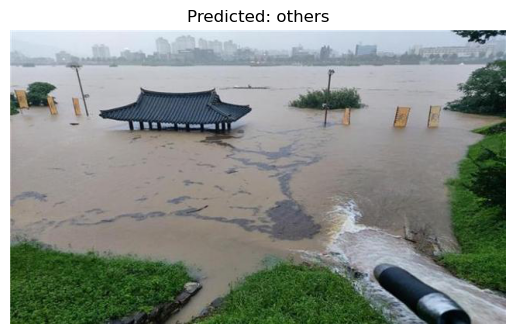

In [11]:


# =============================
# 1. 평가용 데이터셋 불러오기
# =============================

# 기존 transform과 동일하게 맞춰야 함
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 전체 데이터셋 평가
def evaluate_model(model, dataloader):
    model.eval()  # 평가 모드
    correct = 0
    total = 0

    with torch.no_grad():  # 기울기 계산 OFF
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    print(f'전체 평가 정확도 : {acc:.4f}')

# =============================
# 2. 샘플 이미지 하나 예측
# =============================

def predict_image(model, image_path):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, 1)

    # 예측 결과 출력
    print(f'파일명: {os.path.basename(image_path)}')
    print(f'예측 결과: {dataset.classes[pred.item()]}')

    # 이미지 시각화
    plt.imshow(Image.open(image_path))
    plt.title(f'Predicted: {dataset.classes[pred.item()]}')
    plt.axis('off')
    plt.show()

# =============================
# 3. 평가 실행
# =============================
evaluate_model(model, dataloader)

# =============================
# 4. 샘플 예측 실행
# =============================
sample_path = '../딥러닝/train_data/others/000002.jpg'  # 테스트할 이미지 경로 (원하는 이미지로 변경)
predict_image(model, sample_path)


In [12]:
# 1. 학습 루프 (train_loader 사용)
...

# 2. 검증 루프 (val_loader 사용)
model.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

val_acc = val_correct / val_total
print(f'Validation Accuracy: {val_acc:.4f}')


Validation Accuracy: 0.9703
